<a href="https://colab.research.google.com/github/abderrazzaq-laanaoui/spark_drafts/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initilazing the environment

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
# To find out path where pyspark installed
import findspark
findspark.init()

Saprk UI URL

In [ ]:
from google.colab import output
output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

<IPython.core.display.Javascript object>

# Part 1

### 9. Study the code of WordCount executed in the previous step:

The class WordCountt is a classic example of a **MapReduce** application written for the **Apache Hadoop** framework. It's designed to perform a **word count**, which is a common task in data processing, where it counts the number of occurrences of each word in a set of input data.

Here's a breakdown of the key components of this class:

- **TokenizerMapper**: This is the `Mapper` class. It takes text input and breaks it down into words (tokens). Each word is then emitted as a key-value pair, with the word as the key and the number 1 as the value.
```java
  public static class TokenizerMapper
       extends Mapper<Object, Text, Text, IntWritable>{
    
    private final static IntWritable one = new IntWritable(1);
    private Text word = new Text();
      
    public void map(Object key, Text value, Context context
                    ) throws IOException, InterruptedException {
      StringTokenizer itr = new StringTokenizer(value.toString());
      while (itr.hasMoreTokens()) {
        word.set(itr.nextToken());
        context.write(word, one);
      }
    }
  }
```

- **IntSumReducer**: This is the `Reducer` class. It receives all the values that share the same key as an iterable list and sums them up. The total count for each word is then emitted as a key-value pair, with the word as the key and the sum as the value.
```java
  public static class IntSumReducer
       extends Reducer<Text,IntWritable,Text,IntWritable> {
    private IntWritable result = new IntWritable();

    public void reduce(Text key, Iterable<IntWritable> values,
                       Context context
                       ) throws IOException, InterruptedException {
      int sum = 0;
      for (IntWritable val : values) {
        sum += val.get();
      }
      result.set(sum);
      context.write(key, result);
    }
  }
```

- **main method**: This is the entry point of the application. It configures the job, sets the input and output paths, and then starts the MapReduce job. If the job completes successfully, it exits with code 0; otherwise, it exits with code 1.
```java
  public static void main(String[] args) throws Exception {
    Configuration conf = new Configuration();
    String[] otherArgs = new GenericOptionsParser(conf, args).getRemainingArgs();
    if (otherArgs.length < 2) {
      System.err.println("Usage: wordcount <in> [<in>...] <out>");
      System.exit(2);
    }
    Job job = Job.getInstance(conf, "word count");
    job.setJarByClass(WordCount.class);
    job.setMapperClass(TokenizerMapper.class);
    job.setCombinerClass(IntSumReducer.class);
    job.setReducerClass(IntSumReducer.class);
    job.setOutputKeyClass(Text.class);
    job.setOutputValueClass(IntWritable.class);
    for (int i = 0; i < otherArgs.length - 1; ++i) {
      FileInputFormat.addInputPath(job, new Path(otherArgs[i]));
    }
    FileOutputFormat.setOutputPath(job,
      new Path(otherArgs[otherArgs.length - 1]));
    System.exit(job.waitForCompletion(true) ? 0 : 1);
  }
```

### 11. In the previous image what is: Resource manager, history server,
name node, node manager, and data node?
In the  Docker image for Hadoop, the components mentioned are integral parts of the Hadoop ecosystem, These components work together to enable distributed storage and processing of large data sets across a cluster of computers using Hadoop.

- **Resource Manager**: This is the master daemon of YARN (Yet Another Resource Negotiator), responsible for managing the cluster's resources and scheduling applications like MapReduce jobs. It tracks the resources in the cluster and allocates them as needed.

- **History Server**: Part of the MapReduce framework, the History Server provides information about finished applications. It allows users to query the status of applications that have completed their execution.

- **Name Node**: The Name Node is the centerpiece of the Hadoop Distributed File System (HDFS). It manages the file system's namespace and metadata, such as the file directory structure, file attributes, and the location of the file's data blocks across the cluster.

- **Node Manager**: A per-machine agent in YARN that is responsible for containers on a node. It manages the execution of tasks, monitors their resource usage (CPU, memory, disk, network), and reports back to the Resource Manager.

- **Data Node**: A slave node in HDFS that stores the actual data. Data Nodes are responsible for serving read and write requests for the data blocks they store, as instructed by the Name Node. They also handle block creation, deletion, and replication upon instructions from the Name Node.




# Part 2

### 1. Setup PySpark

In [ ]:
!echo "HELLO ENSIBS HELLO VANNES HELLO CYBERLOG ENSIBS IS A SCHOOL IN VANNES" >> text.txt

In [ ]:
# Create SparkSession and sparkcontext
from pyspark.sql import SparkSession
spark = SparkSession.builder\
                    .master("local")\
                    .appName('Firstprogram')\
                    .getOrCreate()
sc=spark.sparkContext
spark

### 2. WordCount Application

In [ ]:
# Read the input file and Calculating words count
text_file = sc.textFile("text.txt")
counts = text_file.flatMap(lambda line: line.split(" ")) \
                            .map(lambda word: (word, 1)) \
                           .reduceByKey(lambda x, y: x + y)

In [ ]:
# Printing each word with its respective count
output = counts.collect()
for (word, count) in output:
    print("%s: %i" % (word, count))

HELLO: 3
ENSIBS: 2
VANNES: 2
CYBERLOG: 1
IS: 1
A: 1
SCHOOL: 1
IN: 1


### 3. Visualise jobs used by the application via Spark UI.
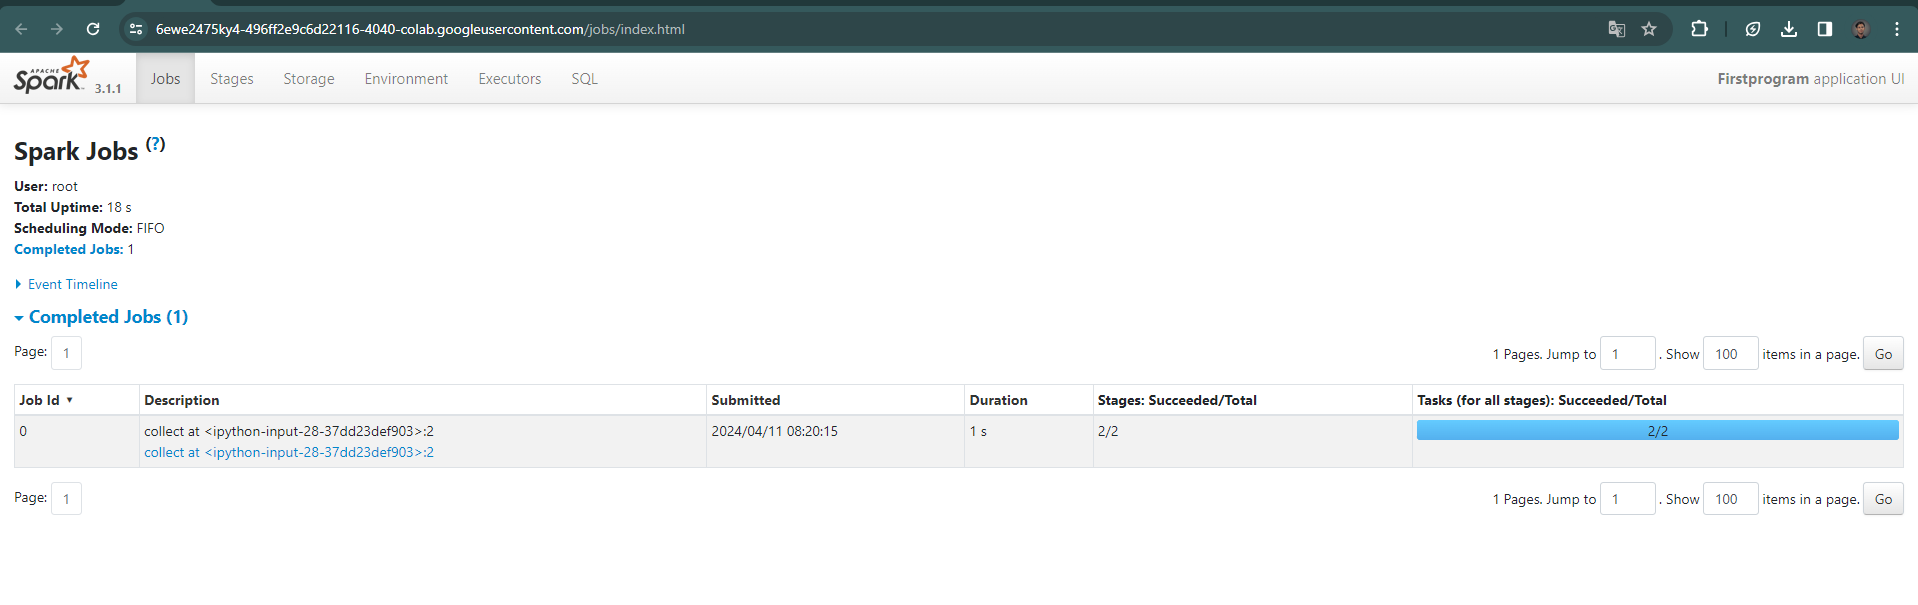

### 4.	The method reduceByKey is lazily executed. What does this mean?
We refer to it as "lazily executed" because when we call reduceByKey, Spark doesn't immediately perform the reduction operation. Instead, it builds up a directed acyclic graph (DAG) of the operations (transformations) called on the RDDs. These transformations are only applied when an action is called, such as collect(), count(), or saveAsTextFile(). So, although we call reduceByKey, Spark postpones the actual execution of the reduction operation until it's necessary for an action.




### 5.	What are the differences between persist() and cache()?
 Both persist() and cache() are used to persist RDDs (or DataFrames/Datasets) in memory, but persist() provides more options for storage levels. The key differences are:
•	cache(): This is a shorthand for persist() with the default storage level (MEMORY_ONLY). It caches the RDD in memory.
•	persist(): This method allows us to specify the storage level explicitly. We can choose among different storage levels like MEMORY_ONLY, MEMORY_AND_DISK, DISK_ONLY, etc. Additionally, persist() returns the same RDD, so we can continue to use it in subsequent operations.

### 6.	Does using persist() always improve the performance of Apache Spark? Explain your answer.
Not necessarily. The decision to use persist() depends on various factors such as the size of our data, available memory, the pattern of our Spark job, and the characteristics of the cluster. While persisting RDDs in memory can improve performance by reducing the need to recompute RDDs between actions, it also incurs overhead in terms of memory usage and management. If our RDDs fit comfortably in memory and are reused multiple times in our workflow, persisting them can be beneficial. However, if memory constraints are tight or if RDDs are only used once, persisting them might not provide significant performance gains and could even degrade performance due to the overhead of managing cached data. So, it's important to profile our Spark application and consider these factors before deciding to use persist().

In [ ]:
sc.stop()

# Part 3

In [ ]:
from pyspark import SparkContext
sc = SparkContext("local", "PairRDD Example")

# Create two RDDs with key/value pairs
rdd1 = sc.parallelize([("apple", 2), ("orange", 3), ("banana", 1), ("apple", 1)])
rdd2 = sc.parallelize([("orange", 4), ("apple", 1), ("banana", 2), ("kiwi", 3)])

### groupByKey transformation

In [ ]:
grouped_rdd1 = rdd1.groupByKey().mapValues(list)
print("groupByKey result:", grouped_rdd1.collect())

groupByKey result: [('apple', [2, 1]), ('orange', [3]), ('banana', [1])]


### reduceByKey transformation

In [ ]:
reduced_rdd1 = rdd1.reduceByKey(lambda a, b: a + b)
print("reduceByKey result:", reduced_rdd1.collect())

reduceByKey result: [('apple', 3), ('orange', 3), ('banana', 1)]


### sortByKey transformation

In [ ]:
sorted_rdd1 = reduced_rdd1.sortByKey()
print("sortByKey result:", sorted_rdd1.collect())

sortByKey result: [('apple', 3), ('banana', 1), ('orange', 3)]


### join transformation

In [ ]:
joined_rdd = rdd1.join(rdd2)
print("join result:", joined_rdd.collect())

join result: [('orange', (3, 4)), ('banana', (1, 2)), ('apple', (2, 1)), ('apple', (1, 1))]


In [ ]:
sc.stop()

# Part 4

### Log analyse :
Based on the line from the Apache server log, the different parts of the log entry can be broken down as follows:

- **IP Address (%h):** 49.113.80.0 - The IP address of the client (host) making the request. This can be either an IPv4 or IPv6 address.
- **Remote logname (%l):** - - The identity of the client determined by identd on the client’s machine. This is often not used and is represented by a hyphen.
- **Remote user (%u):** - - The user ID of the client if the request was authenticated. If not, it is represented by a hyphen.
- **Date and Time (%t):** [01/Oct/2013:23:59:45 +0900] - The date and time of the request.
- **Request Line (%r):** "GET /pub/Linux/debian-cd/7.1.0/amd64/iso-dvd/debian-7.1.0-amd64-DVD-1.iso HTTP/1.1" - The request line from the client, which includes the method (GET), the requested resource (URL path), and the HTTP protocol version.
- **Status Code (%>s):** 206 - The status code that the server sends back to the client.
- **Size of the Object Returned (%b):** 583571 - The size of the object returned to the client, in bytes.
- **Referer (%{Referer}i):** "http://ftp.jaist.ac.jp/pub/Linux/debian-cd/7.1.0/amd64/iso-dvd/" - The referer URL, which indicates the page that linked to this URL.
- **User-Agent (%{User-Agent}i):** "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.2; Trident/4.0; .NET4.0C; .NET4.0E)" - The browser or tool used to make the request.
- **FTP Server Address:** ftp.jaist.ac.jp - The address of the FTP server from which the resource was requested.


### 0. Initialisation

**1. Downloading Logs**

In [ ]:
!curl -O https://www.iijlab.net/~kjc/classes/sfc2016s-measurement/sample_access_log.zip
!unzip sample_access_log.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.5M  100 20.5M    0     0  8830k      0  0:00:02  0:00:02 --:--:-- 8831k
Archive:  sample_access_log.zip
  inflating: sample_access_log       


**2. Parsing logs**

In [ ]:
from pyspark import SparkContext
import re
import matplotlib.pyplot as plt

In [ ]:
# Initialize SparkContext
sc = SparkContext("local", "Log Parser")

# Load the log file
log_file = sc.textFile("sample_access_log")  # Replace with the actual path to your log file

# Define a regular expression pattern to parse each line of the log file
# This pattern accounts for missing information represented by a hyphen
log_pattern = r'(\S+) - - \[(.*?)\] \"(.*?)\" (\d{3}) (\d+|-) \"(.*?)\" \"(.*?)\" (\S+)'


In [ ]:
# Function to match the log pattern and extract the relevant parts
def match_log_pattern(line):
    match = re.match(log_pattern, line)
    if match is not None:
        return match.groups()
    else:
        return None

# Apply the function to each line and filter out None values
parsed_logs = log_file.map(match_log_pattern).filter(lambda x: x is not None)


### 1. The number of lines in this file


In [ ]:
num_lines = parsed_logs.count()
print(f"The number of lines in the file: {num_lines}")

The number of lines in the file: 723509


### 2. The first 10 IP addresses

In [ ]:
first_ten_ips = parsed_logs.map(lambda groups: groups[0]).take(10)
print("The first ten IP addresses:")
for ip in first_ten_ips:
    print(ip)


The first ten IP addresses:
117.136.16.0
218.234.160.0
119.80.32.0
218.234.160.0
117.136.0.0
123.224.224.0
123.224.224.0
124.41.64.0
117.136.0.0
121.110.16.0


### 3. Print only IPv6 addresses


In [ ]:
ipv6_pattern = r'([0-9a-fA-F:]+:+)+[0-9a-fA-F]+'
ipv6_addresses = parsed_logs.map(lambda groups: groups[0]) \
                            .filter(lambda ip: re.match(ipv6_pattern, ip)) \
                            .distinct() \
                            .collect()
print("IPv6 addresses:")
for ip in ipv6_addresses:
    print(ip)


IPv6 addresses:
2001:df0:9c:a909:a949:4291:4a2b:3ccb
2001:41c9:1:a909:a949:4291:c02d:5d13
2404:1100:1ff:a909:a949:4291:4021:88bb
2404:4800::a909:a949:4291:4023:489
2001:da8:203:a909:a949:4291:4023:489
240b:12:24e0:a909:a949:4291:4023:186
2404:4800::a909:a949:4291:4021:5177
2001:e68:2000:a909:a949:4291:4022:19b1
2406:3000:3:a909:a949:4291:4e2d:b556
2001:3e0::a909:a949:4291:40a0:27f
2400:4020:894e:a909:a949:4291:40a0:27f
2404:4800:20:a909:a949:4291:4022:5905
240f:a:9cc5:a909:a949:4941::1
2001:308:3:a909:a949:4291:6020:2021
2620:101:4035:a909:a949:4291:c02d:5d13
2001:288:7031:a909:a949:4291:4020:c298
2001:288:335a:a909:a949:4291:4021:bfca
2001:2f8::a909:a949:4291:c02d:5d13
2001:b020:b:a909:a949:4291:4020:c298
2001:398:1e:a909:a949:4291:c02d:5d13
2403:2800::a909:a949:4291:4461:ea15
240f:16:2d5e:a909:a949:4941::1
2001:2f8:1c1:a909:a949:4291:c02d:5d13
2001:da8:201:a909:a949:4291:4022:41d6
2001:288:323a:a909:a949:4291:4025:56b
2001:fb0:1061:a909:a949:4291:4021:ec94
240f:c:9a33:a909:a949:4941:

### 4. Plot the rate of requests per hour

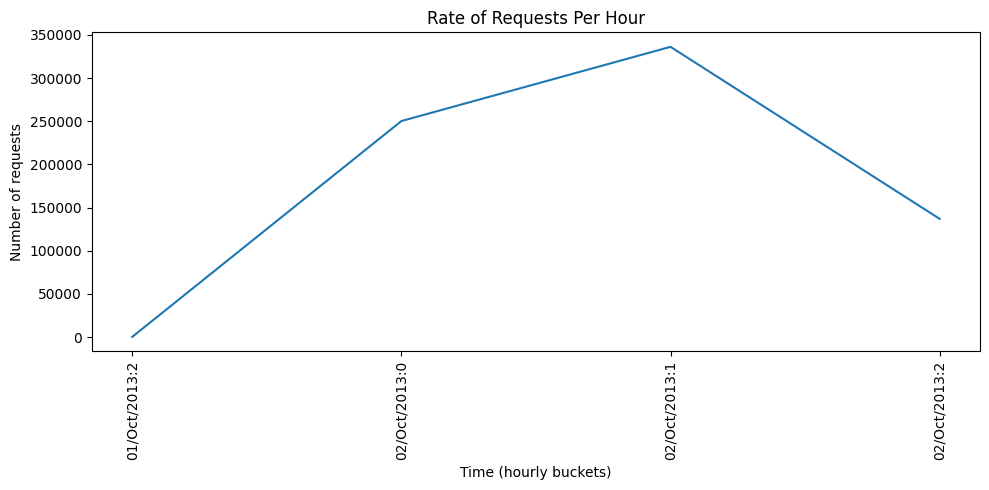

In [ ]:
# Extract the timestamp from each log entry
timestamps = parsed_logs.map(lambda groups: groups[1])

# Convert timestamps to hourly buckets and count the number of requests per hour
requests_per_hour = timestamps.map(lambda ts: (ts[:13], 1)) \
                              .reduceByKey(lambda a, b: a + b) \
                              .sortByKey() \
                              .collect()

# Prepare data for plotting
times = [req[0] for req in requests_per_hour]
counts = [req[1] for req in requests_per_hour]

# Plot the rate of requests
plt.figure(figsize=(10, 5))  # Adjust the size as needed
plt.plot(times, counts)
plt.xticks(rotation=90)
plt.xlabel('Time (hourly buckets)')
plt.ylabel('Number of requests')
plt.title('Rate of Requests Per Hour')
plt.tight_layout()
plt.show()

In [ ]:
sc.stop()

---
